In [1]:
import gzip
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm
import string

In [2]:
## DATA PROCESSING

In [3]:
# interaction splits
# interactions_test = pd.read_csv('datasets/interactions_test.csv')
# interactions_train = pd.read_csv('datasets/interactions_train.csv')
# interactions_validation = pd.read_csv('datasets/interactions_validation.csv')

In [4]:
# interactions_test.head()

In [5]:
# preprocessed data for result reproduction
# pp_recipes = pd.read_csv('datasets/pp_recipes.csv')
# pp_users = pd.read_csv('datasets/pp_users.csv')

In [6]:
# pp_recipes.head(3)

In [7]:
# pp_users.head(3)

In [8]:
# raw data
raw_interactions = pd.read_csv('datasets/raw_interactions.csv')
raw_recipes = pd.read_csv('datasets/raw_recipes.csv')

In [9]:
raw_interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [10]:
raw_recipes.head(3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13


In [11]:
# DATA CLEANING

# drop nulls
raw_recipes.dropna(inplace=True)
raw_interactions.dropna(inplace=True)

# conversion to datetime objects
raw_recipes['submitted'] = pd.to_datetime(raw_recipes['submitted'], format='%Y-%m-%d')
raw_interactions['date'] = pd.to_datetime(raw_interactions['date'], format='%Y-%m-%d')

# check column types
recipes_column_types = raw_recipes.dtypes
interactions_column_types = raw_interactions.dtypes
print('Recipes Column Types:')
print(recipes_column_types)
print('Interactions Column Types:')
print(interactions_column_types)

Recipes Column Types:
name                      object
id                         int64
minutes                    int64
contributor_id             int64
submitted         datetime64[ns]
tags                      object
nutrition                 object
n_steps                    int64
steps                     object
description               object
ingredients               object
n_ingredients              int64
dtype: object
Interactions Column Types:
user_id               int64
recipe_id             int64
date         datetime64[ns]
rating                int64
review               object
dtype: object


In [12]:
## EXPLORATORY ANALYSIS

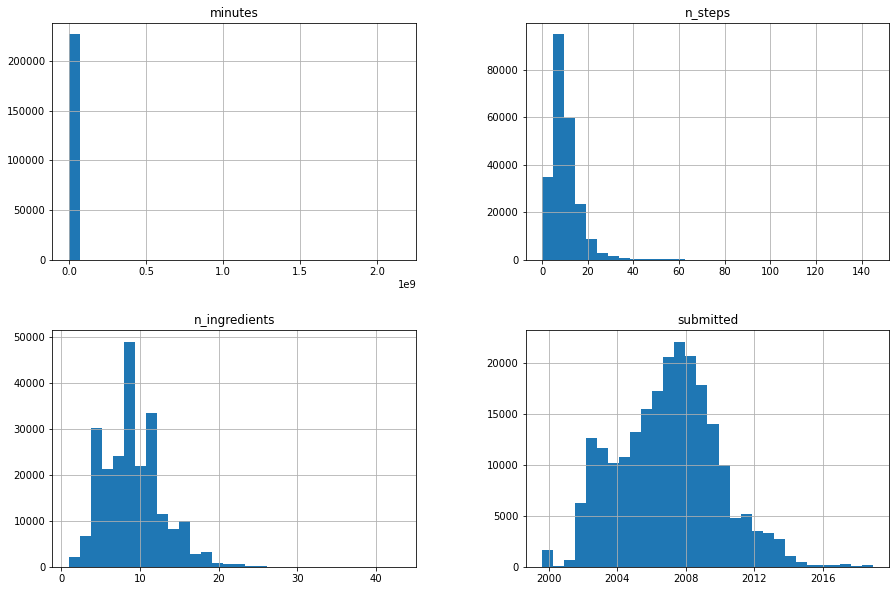

Minutes Summary Stats:
count    2.266570e+05
mean     9.602472e+03
std      4.510715e+06
min      0.000000e+00
25%      2.000000e+01
50%      4.000000e+01
75%      6.500000e+01
max      2.147484e+09
Name: minutes, dtype: float64
Number of Steps Summary Stats:
count    226657.000000
mean          9.773927
std           5.999824
min           0.000000
25%           6.000000
50%           9.000000
75%          12.000000
max         145.000000
Name: n_steps, dtype: float64
Number of Ingredients Summary Stats:
count    226657.000000
mean          9.054170
std           3.740942
min           1.000000
25%           6.000000
50%           9.000000
75%          11.000000
max          43.000000
Name: n_ingredients, dtype: float64
Submission Date Summary Stats:
count                           226657
mean     2006-12-22 20:53:20.176478208
min                1999-08-06 00:00:00
25%                2004-12-08 00:00:00
50%                2007-02-17 00:00:00
75%                2008-11-11 00:00:00
max 

In [13]:
# RECIPES

# analyze numerical columns
numerical_recipes = raw_recipes[['minutes', 'n_steps', 'n_ingredients', 'submitted']]
numerical_recipes.hist(bins=30, figsize=(15,10))
plt.show()

# get summary statistics
print("Minutes Summary Stats:")
print(raw_recipes['minutes'].describe())

print("Number of Steps Summary Stats:")
print(raw_recipes['n_steps'].describe())

print("Number of Ingredients Summary Stats:")
print(raw_recipes['n_ingredients'].describe())

print("Submission Date Summary Stats:")
print(raw_recipes['submitted'].describe(datetime_is_numeric=True))

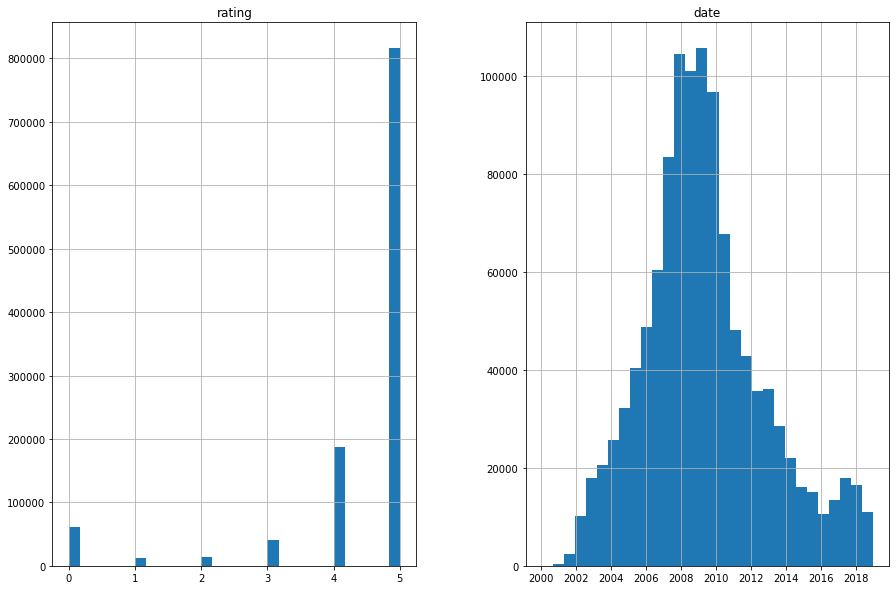

Recipe Ratings Summary Stats:
count    1.132198e+06
mean     4.410971e+00
std      1.264812e+00
min      0.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64
Submission Date Summary Stats:
count                          1132198
mean     2009-05-12 16:06:39.593711360
min                2000-01-25 00:00:00
25%                2007-03-11 00:00:00
50%                2008-12-28 00:00:00
75%                2011-03-06 00:00:00
max                2018-12-20 00:00:00
Name: date, dtype: object


In [14]:
# INTERACTIONS

# analyze numerical variables
numerical_interactions = raw_interactions[['rating', 'date']]
numerical_interactions.hist(bins=30, figsize=(15,10))
plt.show()

# get summary statistics
print("Recipe Ratings Summary Stats:")
print(raw_interactions['rating'].describe())

print("Submission Date Summary Stats:")
print(raw_interactions['date'].describe(datetime_is_numeric=True))

                      id   minutes  contributor_id   n_steps  n_ingredients
id              1.000000  0.000533        0.115105  0.064795       0.039712
minutes         0.000533  1.000000       -0.000108 -0.000263      -0.000599
contributor_id  0.115105 -0.000108        1.000000  0.038882       0.019741
n_steps         0.064795 -0.000263        0.038882  1.000000       0.427783
n_ingredients   0.039712 -0.000599        0.019741  0.427783       1.000000


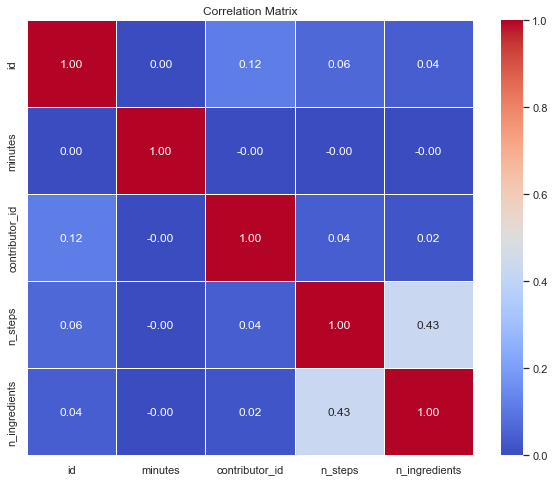

In [15]:
# investigate correlations in recipes
recipes_corr_matrix = raw_recipes.corr()
print(recipes_corr_matrix)

# create heatmap to visualize correlations
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(recipes_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

                            OLS Regression Results                            
Dep. Variable:                n_steps   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                 5.077e+04
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:30:02   Log-Likelihood:            -7.0481e+05
No. Observations:              226657   AIC:                         1.410e+06
Df Residuals:                  226655   BIC:                         1.410e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.5620      0.030    119.407

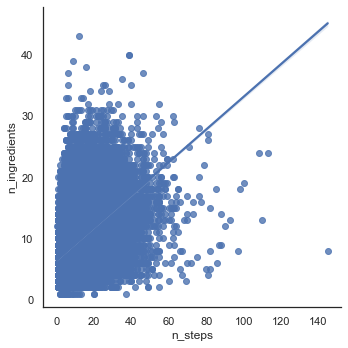

In [16]:
# investigate correlation between n_steps and n_ingredients
x, y = patsy.dmatrices('n_steps ~ n_ingredients', raw_recipes)
mod_1 = sm.OLS(x, y)
res_1 = mod_1.fit()
print(res_1.summary())
sns.lmplot(data = raw_recipes, y = 'n_ingredients', x = 'n_steps')

            user_id  recipe_id    rating
user_id    1.000000   0.099961 -0.196492
recipe_id  0.099961   1.000000 -0.013588
rating    -0.196492  -0.013588  1.000000


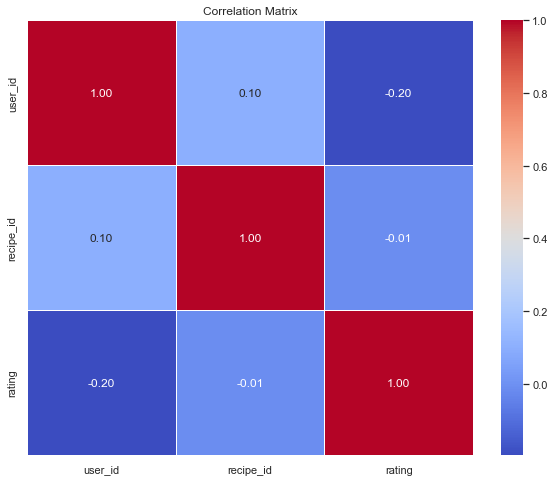

In [17]:
# investigate correlations in interactions
interactions_corr_matrix = raw_interactions.corr()
print(interactions_corr_matrix)

# create heatmap to visualize correlations
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(interactions_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

In [18]:
## TEXT ANALYSIS

In [19]:
## How do capitalized words correlate with rating?

In [20]:
# capture all capitalized words in each review
raw_interactions['review'] = raw_interactions['review'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha() and word.isupper()]))
raw_interactions['capitalized_words'] = raw_interactions['review'].apply(lambda x: x.split())
word_ratings = raw_interactions.explode('capitalized_words').groupby('capitalized_words')['rating'].mean().reset_index()

In [32]:
# explore correlation

# words associated with top 10 highest ratings
best_words = word_ratings.sort_values(by='rating', ascending=False).head(10)
print('Top 10 Words')
print(best_words)

# words associated with top 10 highest ratings
worst_words = word_ratings.sort_values(by='rating').head(10)
print('Worst 10 Words')
print(worst_words)

Top 10 Words
      capitalized_words  rating
4218              NOTES     5.0
4223                NOV     5.0
195   AMAZZZIIINNNGGGGG     5.0
50                ACIDS     5.0
49                  ACE     5.0
38           ABSULUTELY     5.0
7180         YUMMMMYYYY     5.0
7179          YUMMMMYYY     5.0
198            AMBROSIA     5.0
7216    YUUUUMMMMMMMMMM     5.0
Worst 10 Words
     capitalized_words  rating
6591              URGH     0.0
1319             CUBES     0.0
1317              CUBE     0.0
5013           RALEIGH     0.0
4850           PRESENT     0.0
3368           LACTOSE     0.0
1311               CSI     0.0
1469        DEFINENTLY     0.0
1528            DESROS     0.0
1515           DEPENDS     0.0
